# Hand gesture recognition via convolutional neural networks
by Christian Nestroy, Daniel Søholm, Torkil Kristiansen

Project in the course "Deep Neural Networks" at the University of Southern Denmark

## Importing packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

In [4]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
%cd /content/gdrive/MyDrive/DNN/

/content/gdrive/.shortcut-targets-by-id/1K9DYLkU0YJI4Mh5wUhP6DiEDAAw26lWX/DNN


In [6]:
!python /content/gdrive/MyDrive/DNN/download.py

## Data augmentation to enhance to amount and variety of available images

In [7]:
mu = [0.9440, 0.9054, 0.9146]
std = [0.1312, 0.2035, 0.1892]
affine_hflip = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomAffine(
        degrees=10, translate=(.05, .05), 
        shear=(-5, 5), resample=Image.BILINEAR, 
        fillcolor=tuple(np.around(mu).astype(int)),
    ),                        
])

def get_loader(set, batch_size=64, n_valid=2000, augmentations=lambda x: x):
  img_transforms = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()])
  data_train = torchvision.datasets.ImageFolder(root=set,transform=transforms.Compose([augmentations,img_transforms]))
  loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,shuffle=True)
  return loader

## Defining the data normalization and loading

In [8]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
        
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9440, 0.9054, 0.9146],
                    std=[0.1312, 0.2035, 0.1892])
    ])
train_data_loader = get_loader("./train/",augmentations=affine_hflip)
val_data_loader  = get_loader("./val/",augmentations=affine_hflip)
test_data_loader = get_loader("./test/",augmentations=affine_hflip)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda")
else:
    device = torch.device("cpu")
    print("cpu")

cuda


## Topology of convolutional layers for feature extraction

In [9]:
def build_cnn_layer(feat_in, feat_out, k=3, stride=1, padding=1, 
                    batchnorm=True, pool=True):
    return nn.Sequential(
        nn.Conv2d(feat_in, feat_out, k, stride=stride, padding=padding),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(feat_out) if batchnorm else nn.Identity(),
        nn.MaxPool2d(kernel_size = 2, stride = 3) if pool else nn.Identity(),
    )

def build_feature_representation(nf=64, pool=True):
    s = 1 if pool else 2
    return nn.Sequential(
        build_cnn_layer(3, nf, k = 12),  # (B, nf, 32, 32)
        build_cnn_layer(nf, 2 * nf, k = 9, stride=s, pool=pool),  # (B, 2 * nf, 16, 16)
        build_cnn_layer(2 * nf, 4 * nf, k = 5, stride=s, pool=pool),  # (B, 4 * nf, 8, 8)
    )

## Definition of total CNN including fully connected layers for classification

In [10]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=9, nf=32, dropout=True):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            build_feature_representation(nf=nf)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout() if dropout else nn.Identity(),
            nn.Linear(4 * nf * 6 * 6, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Dropout() if dropout else nn.Identity(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, num_classes),
            nn.Softmax()
        )
        self.dropout = dropout

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Function for forward and backward pass of ANN training

In [11]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, n_epochs_stop=3, device="cpu", early_stopping=True):
    min_valid_loss = 20
    epochs_no_improve = 0
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    confusion_matrices = []

    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        num_correct = 0 
        num_examples = 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        training_loss /= len(train_loader.dataset)
        train_acc = num_correct / num_examples
        train_losses.append(training_loss)
        train_accuracies.append(train_acc)
        
        model.eval()
        num_correct = 0 
        num_examples = 0

        nb_classes = 9
        confusion_matrix = torch.zeros(nb_classes, nb_classes)

        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            _, preds = torch.max(output, 1)
            for t, p in zip(targets.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        confusion_matrices.append(confusion_matrix)

        valid_loss /= len(val_loader.dataset)
        valid_acc = num_correct / num_examples
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        if valid_loss < min_valid_loss:
          epochs_no_improve = 0
          min_valid_loss = valid_loss
          best_model = model
          best_epoch = epoch
        else:
          epochs_no_improve += 1
          if (epochs_no_improve == n_epochs_stop) and early_stopping:
            torch.save(best_model.state_dict(), "/CNN")
            last_epoch = epoch
            print('Early stopping!')
            break

        print('Epoch: {}, Training Loss = {:.3f}, Validation Loss = {:.3f}, Training accuracy = {:.3f}, Validation accuracy = {:.3f}'.format(epoch, training_loss,
        valid_loss, train_acc, valid_acc))

    print('best epoch: ' + str(best_epoch))
    ax = sns.heatmap(confusion_matrices[best_epoch] / confusion_matrices[best_epoch].sum(), annot=True, fmt='.2%', 
                      cmap='Blues', cbar=False, yticklabels='auto')
    ax.set_ylabel('ground truth')
    ax.set_xlabel('predicted')

    return train_losses, valid_losses, train_accuracies, valid_accuracies

## Function for plotting progression of ANN training

In [12]:
def plot_history(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('losses, dropout = ' + str(cnnnet.dropout))
    p = plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.ylim(0, 2)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracies, dropout = ' + str(cnnnet.dropout))
    p = plt.plot(train_accuracies, label='train')
    plt.plot(valid_accuracies, label='valid')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# ANN instantiation, compiling and training

In [13]:
cnnnet = CNNNet(dropout=True)

In [14]:
print(cnnnet)

CNNNet(
  (features): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(12, 12), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1

In [15]:
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.0001, weight_decay=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss = 2.166, Validation Loss = 2.202, Training accuracy = 0.234, Validation accuracy = 0.077
Epoch: 1, Training Loss = 1.960, Validation Loss = 2.211, Training accuracy = 0.547, Validation accuracy = 0.077
Epoch: 2, Training Loss = 1.819, Validation Loss = 2.214, Training accuracy = 0.623, Validation accuracy = 0.077
Epoch: 3, Training Loss = 1.736, Validation Loss = 2.199, Training accuracy = 0.709, Validation accuracy = 0.165
Epoch: 4, Training Loss = 1.657, Validation Loss = 2.128, Training accuracy = 0.785, Validation accuracy = 0.242
Epoch: 5, Training Loss = 1.629, Validation Loss = 1.991, Training accuracy = 0.777, Validation accuracy = 0.440
Epoch: 6, Training Loss = 1.567, Validation Loss = 1.911, Training accuracy = 0.860, Validation accuracy = 0.527
Epoch: 7, Training Loss = 1.559, Validation Loss = 1.819, Training accuracy = 0.842, Validation accuracy = 0.615
Epoch: 8, Training Loss = 1.539, Validation Loss = 1.792, Training accuracy = 0.868, Validation 

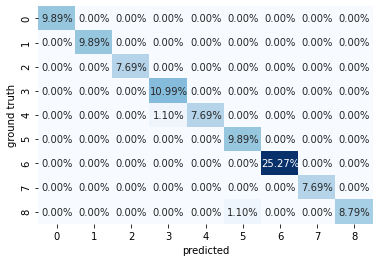

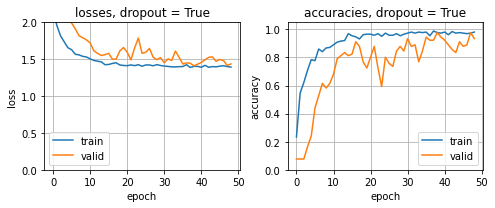

In [ ]:
plot_history(*train(cnnnet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=50, device=device, n_epochs_stop=10))

# Same process as above without regularization by Dropout

In [ ]:
cnnnet = CNNNet(dropout=False)

In [ ]:
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.0001, weight_decay=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss = 2.027, Validation Loss = 2.186, Training accuracy = 0.347, Validation accuracy = 0.253
Epoch: 1, Training Loss = 1.749, Validation Loss = 2.140, Training accuracy = 0.645, Validation accuracy = 0.253
Epoch: 2, Training Loss = 1.665, Validation Loss = 2.114, Training accuracy = 0.721, Validation accuracy = 0.253
Epoch: 3, Training Loss = 1.573, Validation Loss = 2.116, Training accuracy = 0.826, Validation accuracy = 0.253
Epoch: 4, Training Loss = 1.516, Validation Loss = 2.058, Training accuracy = 0.875, Validation accuracy = 0.286
Epoch: 5, Training Loss = 1.491, Validation Loss = 1.895, Training accuracy = 0.898, Validation accuracy = 0.484
Epoch: 6, Training Loss = 1.518, Validation Loss = 1.903, Training accuracy = 0.868, Validation accuracy = 0.462
Epoch: 7, Training Loss = 1.519, Validation Loss = 1.847, Training accuracy = 0.857, Validation accuracy = 0.516
Epoch: 8, Training Loss = 1.480, Validation Loss = 1.787, Training accuracy = 0.902, Validation 

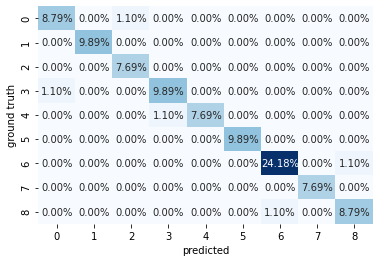

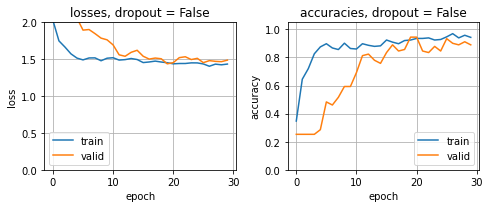

In [ ]:
plot_history(*train(cnnnet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=50, device=device, n_epochs_stop=10))

## Transfer learning with pretrained AlexNet backbone provided by PyTorch

In [16]:
import torchvision.models as models
alexnet = models.alexnet(num_classes=1000, pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 9)
alexnet.classifier.add = nn.Softmax()

In [19]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss = 2.067, Validation Loss = 1.865, Training accuracy = 0.298, Validation accuracy = 0.549
Epoch: 1, Training Loss = 1.827, Validation Loss = 1.706, Training accuracy = 0.566, Validation accuracy = 0.725
Epoch: 2, Training Loss = 1.668, Validation Loss = 1.545, Training accuracy = 0.743, Validation accuracy = 0.934
Epoch: 3, Training Loss = 1.574, Validation Loss = 1.465, Training accuracy = 0.864, Validation accuracy = 0.956
Epoch: 4, Training Loss = 1.463, Validation Loss = 1.478, Training accuracy = 0.928, Validation accuracy = 0.890
Epoch: 5, Training Loss = 1.447, Validation Loss = 1.449, Training accuracy = 0.947, Validation accuracy = 0.923
Epoch: 6, Training Loss = 1.474, Validation Loss = 1.406, Training accuracy = 0.906, Validation accuracy = 0.978
Epoch: 7, Training Loss = 1.422, Validation Loss = 1.406, Training accuracy = 0.962, Validation accuracy = 0.967
Epoch: 8, Training Loss = 1.411, Validation Loss = 1.394, Training accuracy = 0.970, Validation 

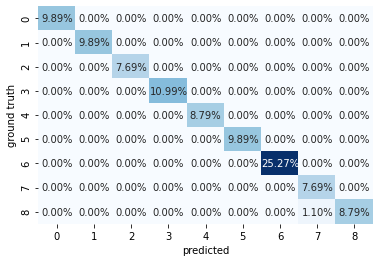

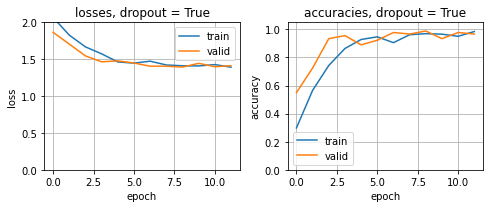

In [17]:
alexnet.to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001, weight_decay=0.01)
plot_history(*train(alexnet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=30, device=device, early_stopping=True))

It is evident that training converges faster when using the pretrained Alexnet backbone.